# Algoritmos Genéticos

<img src='https://github.com/shivamshekhar/Chrome-T-Rex-Rush/raw/master/screenshot.gif'>

Algoritmos genéticos (AGs) são uma classe de algoritmos de otimização inspirada no processo evolutivo biológico, que fazem parte do que se chama de computação evolutiva. AGs são inspirados em modelos biológicos, e se fundamentam na Genética de Mendel (1965) e também na Teoria da Evolução de Darwin (1959), usando uma medida para avaliar a capacidade que os indivíduos de uma população têm para sobriver e se reproduzir.

Dessa forma, espera-se que as características dos indivíduos ''mais aptos'', que se reproduzem, em uma geração sejam  transferidas para a próxima geração. Podemos definir como um pseudocódigo do AG o seguinte:


    ENTRADA: População Inicial (aleatória)
             Função de Fitness
             Critério de Parada
             
    REPITA (até que o critério de parada seja atendido):
    
        PASSO 1: Aplicar a função de fitness a cada indivíduo
        PASSO 2: Selecionar os x melhores indivíduos
        PASSO 3: Reprodução
                - Aplicar o crossover a um par (com prob = p)
                - Aplicar mutação (com prob = p’)
        PASSO 4: Formar uma nova população com os filhos gerados
  
  
    SAÍDA: Melhor indivíduo presente na geração final    

## O que iremos fazer?

Neste *notebook*, iremos utilizar AGs para criar um modelo capaz de jogar o [chrome-trex-rush](https://github.com/fernandokm/chrome-trex-rush) -- uma versão, em Python, do *game* T-Rex embutido no Google Chrome. 

Assim, o nosso modelo que controlará o dinossauro poderá assumir três possíveis ações:
    - Não fazer nada (e continuar correndo)
    - Pular (os cactus)
    - Agachar (dos pterossauros)


Em geral, as nossas <mark>variáveis de entrada</mark> são parâmetros que nos <mark>dizem coisas sobre o nosso problema</mark>. No caso do dinossauro, poderia ser a **distância até o próximo obstáculo**, a **velocidade**, a **altura do próximo obstáculo**, etc. <mark>Lembrando que o jogo é dinâmico</mark>, ou seja, essas variáveis estão em constante mudança, a cada tomada de decisão, rodamos mais uma decisão com outros valores. **Esse vetor com essas variáveis é chamado de “estado do jogo”.**

Nossa função de decisão não nos retornará um número, mas sim um vetor com três números (um para cada ação) e nós vamos escolher a ação cuja função nos dê o maior output dentre os três.

--


Para instalarmos o pacote do jogo, basta executar a célula abaixo:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from chrome_trex import DinoGame


CHANCE_MUT = .2      # Chance de mutação de um peso qualquer
NUM_INDIVIDUOS = 20  # Tamanho da população
NUM_MELHORES = 5     # Número de indivíduos que são mantidos de uma geração para a próxima

In [2]:
def ver_individuo(individuo :np.array, ax :plt.axis=None):
    """Função vizualização de indivíduos
    
    Parameters
    ----------
    individuo : np.array
        Matriz 3x10 com os pesos do indivíduo.
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2))

    sns.heatmap(individuo,annot=True, fmt='.2f', cmap='gray', ax=ax)

    ax.set_yticklabels(['Correr', 'Pular', 'Agachar'], rotation=0)
    ax.set_xticklabels(['$w_{p}$'.replace('p', str(x+1)) for x in range(10)], rotation=0)

## População

> **Definição:** A populaçao é formada por um conjunto de indivíduos que irão competir pela sobrevivência e pela repodrução, objetivando perpetuar suas características.

Como vimos no pseudo-código, mais em cima, uma das entradas do algorimto genético é uma população (inicialmente, gerada aleatoriamente). Para isso, vamos criar vários indivíduos com <mark>pesos</mark>.

### Código Genético e Pesos (ou genes)

Cada indivíduo possui seu próprio código genético, que determina suas características e desempenho no ambiente em que vive. Da mesma forma, em AGs, existem parâmetros que influenciam na tomada de decisão dos modelos e, consequentemente, seu desempenho.

> Imagine que tenhamos que criar um modelo, usando AGs, para investir na bolsa de valores de modo que queremos maximizar o nosso lucro. Nossa IA pode ''aprender'' a levar em conta o valor do ativo, bem como notícias relacionadas ao mercado e outras variáveis, para poder inferir se irá ou não fazer um investimento.

No exemplo acima, a taxa de valorização de cada variável para a tomada de decisão do modelo é chamada de **peso**, e determina seu sucesso. Essas taxas são obtidas através de uma <mark>função de tomada de decisão</mark> e, comparando com conceitos da biologia, essa função seria algo análogo ao genoma de uma espécie, enquanto os pesos seriam associados às diferenças que cada organismo da espécie tem em seu DNA.

Se definíssemos uma função linear simples (em que multiplicamos cada variável por um peso e depois somamos tudo), uma IA gerada por esse algoritmo genético que tivesse 3 pesos teria a função de decisão abaixo:

$$
f = \sum_{i=1}^{3} w_i \cdot x_i = [(w_1 \cdot x_1) + (w_2 \cdot x_2) + (w_3 \cdot x_3)]
$$

onde, $x_i$ são os elementos de estado e $w_i$ os pesos respectivos, para dado indivíduo. 

**Spoiler:** essa é a função que vamos adotar no Dino Run! 

Vamos agora utilizar a biblioteca `numpy` para nos ajudar a gerar uma matriz de pesos aleatórios (já iremos ver mais sobre ela):

In [3]:
def populacao_aleatoria(n :int) -> list:
    """Gera uma população aleatória
    
    Parameters
    ----------
    n : int
        Número de indivíduos que serão criados
    
    Returns
    -------
    list
        Uma população aleatória. A população é uma lista de indivíduos,
                                                                                                                                                e cada indivíduo é uma matriz 3x10 de pesos (números).
        Os indivíduos podem tomar 3 ações (0, 1, 2) e cada linha da matriz
        contém os pesos associados a uma das ações, para os componentes.
    """
    pop = []
    
    # Para cada indivíduo, gere uma matriz contendo pesos para cada componente, em cada ação
    for i in range(n):
        pop.append(np.random.uniform(-10, 10, size=(3, 10)))
    
    return pop

Vizualização dos indivíduos:

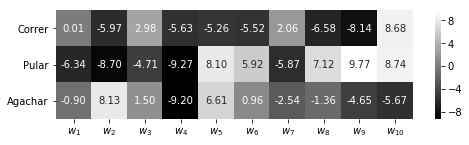

In [4]:
ver_individuo(populacao_aleatoria(1)[0])

- Cada linha da nossa matriz, acima, é um **Gene**

> Genes correspondem a uma representação de algum parâmetro de interesse, de acordo com algum alfabeto, podendo usar valores inteiros, reais e cadeis de caracteres, porém, o mais comum é usar apenas valores 0 e 1 de um alfabeto binário.

- E a matriz, como um todo, é um **Cromosso** (ou indivíduo)

> Cromossos correspondem a uma cadeia de genes que representam cada indivíduo da população.

> Um indivíduo correspode a um cromossomo e, no caso dos algoritmos genéticos, são usados para representar as soluções a serem encontradas em um problema de otimização.

## Função de Decisão

Okay, agora que já montamos nossos indivíduos iniciais, como vamos fazer para nosso AG tomar uma decisão?

A ideia aqui é dividir esse processo em duas funções. A primeira delas, vai aplicar aquelas nossas funções de decisão em si, nos retornando um valor para cada ação, ou seja, um vetor com três números. Já a segunda, vai pegar esse vetor e nos retornar o índice do maior número entre os três.

### Primeira Função: o Valor das Ações

Iremos identificar o ''valor de cada ação'' ($y_i$) através da multiplicação matricial entre o indivíduo ($W$) e o vetor de estado (*i.e.*, as variáveis do jogo, que são 10) ($x_i$).

$$
\begin{bmatrix}
    w_{1;1} & x_{1;2} & x_{1;3} & \dots  & w_{1;10} \\
    w_{2;1} & x_{2;2} & x_{2;3} & \dots  & w_{2;10} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    w_{3;1} & w_{3;2} & w_{3;3} & \dots  & w_{3;10}
\end{bmatrix} \cdot
\begin{bmatrix}
    x_{1} \\
    x_{2} \\
    x_{3} \\
    \vdots \\
    x_{10} \\
\end{bmatrix} = 
\begin{bmatrix}
    y_{1} \\
    y_{2} \\
    y_{3} \\
\end{bmatrix}
$$

Desse modo, a função que calcula o valor das ações fica assim:

In [5]:
def valor_das_acoes(individuo :np.array, estado :np.array) -> np.array:
    """Função para determinar o valor de cada ação
    
    Parameters
    ----------
    individuo : np.array
        Matriz 3x10 com os pesos do indivíduo.
    estado : np.array
        Vetor com 10 números que representam o estado do jogo.
    
    Returns
    -------
    np.array
        Um vetor com os valores das ações no estado `estado`. Calcula os valores
        das jogadas como combinações lineares dos valores do estado, ou seja,
        multiplica a matriz de pesos pelo estado.
    """
    
    return individuo @ estado

## Segunda Função: Pegar o Índice da Melhor Ação

Essa aqui não tem segredo, a gente vai usar uma função do numpy que faz justamente isso: dado um vetor, ela retorna o índice do maior valor.

In [6]:
def melhor_jogada(individuo :np.array, estado: np.array) -> int:
    """Identifica a ação a ser tomada
    
    Parameters
    ----------
    individuo : np.array
        Matriz 3x10 com os pesos do indivíduo.
    estado : np.array
        Vetor com 10 números que representam o estado do jogo.
    
    Returns
    -------
    int
        A ação de maior valor (0, 1 ou 2) calculada pela função `valor_das_acoes`.
    """
    
    acoes = valor_das_acoes(individuo, estado)
    return np.argmax(acoes)

## Gerações & Seleção

> **Definição**: A geração corresponde a uma população em um certo período. No caso, dos algoritmos genéticos, corresponde aos valores dos indivíduos obtidos em uma dada iteração.

> **Definição**: A seleção é usada para escolher os indivíduos para a reprodução, podendo ser realizada de diferentes maneiras, porém, as propostas mais comuns são: a seleção aleatória, a seleção por torneio e a seleção usando a roleta.


<img src='https://media.nature.com/m685/nature-assets/srep/2016/161121/srep37616/images_hires/srep37616-f3.jpg'>


Na natureza, indivíduos mais aptos sobrevivem e se reproduzem com mais frequência, proliferando seu código genético na população. No longo prazo, isso gera populações mais e mais adaptadas ao seu ambiente a cada geração. Porém, linha de códigos não estão sujeitas a adversidades como fome ou incapacidade de encontrar um@ parceir@. <mark>Assim, não se espera observar um fenômeno equivalente, a não ser que seja introduzido um processo artificial</mark>.

Esse processo pode ser realizado, em computação, através de **função de avaliação do indivíduo** (*i.e.* *fitness function*). Essa função é responsável por determinar a aptidão (sucesso ou performance) de um indivíduo na atual geração.

> **Elitismo:** **Seleção somente dos melhores indivíduos criados para uma próxima geração** (baseado na sua função de avaliação), da mesma forma como somente os organismos mais aptos a um habitat conseguem passar pelo crivo da natureza, gerando proles que viverão a próxima geração da espécie.

Os demais indivíduos, então, acabam não sendo selecionados para a próxima geração. Entretanto, estão aptos a reproduzirem. Essa etapa ocorre através do **crossover** entre os genes de dois indivíduos, possibilitando a criação ''filhos'' com, neste caso, 50% da carga genética (ou pesos, ou informação) de cada um dos seus pais. As proles desenvolvidas nesse processo, que ainda estão sujeitas à **mutação**, compõem nova população que irá para a próxima geração, junto com os indivíduos selecionados pelo elitismo.

> Se um algoritmo genético é configurado para ter uma população de tamanho $\texttt{NUM_INDIVIDUOS}=10$ e definimos que os $\texttt{NUM_MELHORES}=3$ indivíduos mais aptos serão repassados diretamente para a próxima geração, então os 7 indivíduos só poderão perpetuar sua espécie, na próxima geração, através *crossover* e mutação das suas proles. Esses 7 indivíduos não aptos devem procriar a quantidade remanescente de indivíduos para a próxima geração.


### Crossing over

In [7]:
def cross_over(a: np.array, b: np.array, n_children :int=1) -> list:
    """Combina dois indivíduos
    
    Parameters
    ----------
    a : np.array
        Matriz 3x10 com os pesos do indivíduo.
    b : np.array
        Matriz 3x10 com os pesos do indivíduo.
    n_children : int, optional
        Qunatidade de filhos a serem gerados, by default 1
    
    Returns
    -------
    list
        Uma lista contendo `n_children` novo(s) indivíduo(s) resultante do 
        cruzamento entre os indivíduos `a` e `b`.
    """
    
    children = []
    
    for i in range(n_children):
        sieve = np.random.choice([0, 1], size=(3, 10), p=[.5, .5])
        not_sieve = sieve^1
        children.append(a*sieve + b*not_sieve)

    return children

Podemos observar um crossover baixo:

In [8]:
ind = populacao_aleatoria(2)
ind

[array([[-3.88756384, -4.14394973, -5.33053477, -3.17153675,  5.06723225,
          8.90912375, -9.28510874,  4.39986073,  6.71958292, -0.96941318],
        [ 8.54146277,  4.17163025,  9.22839166, -0.18739689, -3.92575061,
          5.80919653, -5.2774186 , -9.27510836,  4.59765764,  8.25453574],
        [ 6.77956546, -0.20954534, -0.95971627, -4.60102689,  7.036839  ,
          3.51083033, -4.19553958,  2.42606569, -6.33768948, -9.59166615]]),
 array([[ 5.94970817, -4.35308135, -2.94488243, -1.70207254,  0.85458065,
          8.82919905,  2.11776219,  1.57290228,  1.65385355,  2.59152428],
        [-7.41369518, -3.57473114,  9.43300813,  0.35483614,  7.57359496,
          0.99488367, -4.4657916 ,  8.05868474,  9.90755182,  0.17483715],
        [ 7.37715992,  1.69341478, -8.18550373,  7.98366708,  7.98160866,
         -6.87085481,  7.80425778, -5.34587957,  6.32173577,  7.25902976]])]

Text(0.5, 1.0, 'Indivíduo B')

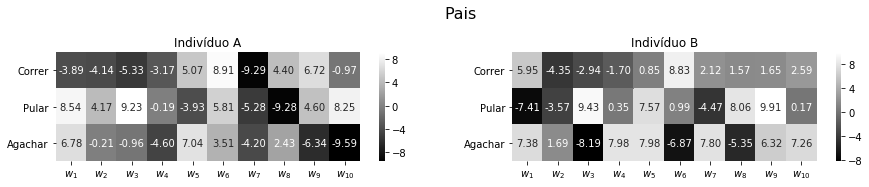

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 2))

fig.suptitle("Pais", y=1.2, fontsize=16)

ver_individuo(ind[0], ax=ax[0])
ax[0].set_title("Indivíduo A")

ver_individuo(ind[1], ax=ax[1])
ax[1].set_title("Indivíduo B")

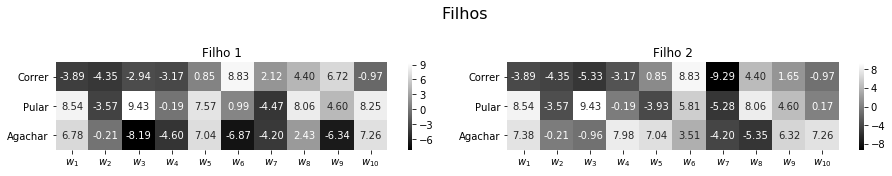

In [10]:
filhos_qtd = 2
filhos = filhos = cross_over(*ind, n_children=filhos_qtd)

fig, ax = plt.subplots(1, filhos_qtd, figsize=(6.5*filhos_qtd, 2))

fig.suptitle("Filhos", y=1.2, fontsize=16)

for i in range(filhos_qtd):
    ver_individuo(filhos[i], ax=ax[i])
    ax[i].set_title("Filho " + str(i+1))
    
plt.tight_layout()

### Mutação

Na função de mutação nós vamos possivelmente mutar os pesos do nosso indivíduo com uma probabilidade definida lá em cima nas nossas variáveis globais

In [11]:
def mutacao(individuo :np.array):
    """Essa função não tem saída. Ela apenas modifica os pesos do indivíduo,
    com chance CHANCE_MUT para cada peso.
    
    Parameters
    ----------
    individuo : np.array
        Matriz 3x10 com os pesos do indivíduo.
    """
    
    for i in range(3):
        for j in range(10):
            if np.random.uniform(0, 1) < CHANCE_MUT:
                individuo[i][j] *= np.random.uniform(-1.5, 1.5)

Podemos observar os efeitos da mutação em um indivíduo aleatório:

Text(0.5, 1.0, 'Após a mutação')

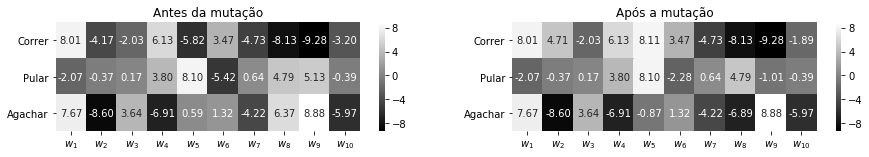

In [12]:
ind = populacao_aleatoria(1)[0]

fig, ax = plt.subplots(1, 2, figsize=(15, 2))

ver_individuo(ind, ax=ax[0])
ax[0].set_title("Antes da mutação")

mutacao(ind)
ver_individuo(ind, ax=ax[1])
ax[1].set_title("Após a mutação")

### T-Rex Rush: Um pouco sobre o jogo


<img src='https://github.com/shivamshekhar/Chrome-T-Rex-Rush/raw/master/screenshot.png'>

Podemos instânciar e iniciar o game da seguinte forma:

In [13]:
trex = DinoGame(fps=60)

Note que passamos como parâmetro `fps=60`. No momento do ''treinamento'' do algoritmo genético, podemos aumentar o *frame rate* para agilizar o processo.

O objeto `DinoGame()` possui alguns métodos/atributos interessantes, vejamos:


| Item                   | Descrição                                                                                      |
|------------------------|------------------------------------------------------------------------------------------------|
| `DinoGame.reset()`     | Método que reinicia o jogo                                                                     |
| `DinoGame.game_over`   | Atributo para verificar se o jogo foi finalizado                                               |
| `DinoGame.step()`      | Método que permite o dinossauro executar uma ação (0-Nada/Corre, 1-Pula, 2-Agacha)             |
| `DinoGame.get_score()` | Método que obtém o score da partida                                                            |
| `DinoGame.get_state()` | Método que obtém as 10 variáveis do jogo (por exemplo, distância do obstáculo, velocidade etc) |

Uma breve demonstração ''burrinha'' :p

In [14]:
t = 5*60 

while t != 0:
    if trex.game_over:
        trex.reset()
    trex.step(np.random.randint(0, 3))
    t -= 1

### Fitness: função de avaliação do indivíduo

Finalmente, vamos fazer nossa função de *fitness* \o/

Chegamos agora num ponto bem importante dos algoritmos genéticos, que é a função de *fitness*. Como dito anteriormente no texto, para simular o mecanismo biológico de seleção natural precisamos artificialmente criar uma pressão do meio. É aí que entra a função de *fitness*: a partir do score dado por ela para um dado indivíduo, é possível comparar a performance dele em relação aos demais.

A nossa função de *fitness* mais simples a ser escolhida (que é o que faremos nesse caso) é o score do jogo, que pode ser obtido pelo método `DinoGame.get_score()`, lembra?

Então, em termos de código, o que a função deve executar é: **fazer com que o indivíduo jogue o jogo e depois pegar o score dele**. Algumas ressalvas são: temos que dar reset no jogo antes de pôr nosso pequeno indivíduo à prova, para que ele comece um jogo novo (e não fique na tela de game over do indivíduo anterior).


In [15]:
def fitness_function(individuo :np.array, game_ob :DinoGame) -> int:
    """Faz o indivíduo jogar uma partida e depois pegar o score que ele conseguiu
    
    Parameters
    ----------
    individuo : np.array
        Matriz 3x10 com os pesos do indivíduo
    game_ob : chrome_trex.dinogame.DinoGame
        Objeto que representa o jogo
    
    Returns
    -------
    int
        O fitness calculado de um indivíduo. Esse cálculo é feito simulando um
        jogo e calculando o fitness com base nessa simulação
    """
    
    game_ob.reset()
    
    while not game_ob.game_over:
        vet_estados = game_ob.get_state() # variáveis do jogo
        acao = melhor_jogada(individuo, vet_estados) # Obtém a ação do dinossauro (corre, pula ou agacha)
        game_ob.step(acao) # Aplica a ação

    return game_ob.get_score()

Vejamos uma demonstração com um indivíduo que criamos mais cedo:

In [16]:
fitness_function(ind, trex)

20

### Próxima Geração

Agora que definimos a nossa função de *fitness*, podemos aplicar o elitismo e a reprodução (crossover e mutação) para gerar a próxima população:

In [17]:
def proxima_geracao(populacao :list, fitness :list) -> list:
    """Cria a próxima geração a partir de elitismo e seleção (crossover + mutação)
    
    Parameters
    ----------
    populacao : list
        Lista com os pesos (Matriz 3x10) dos indivíduos.
    fitness : list
        Lista de scores
    
    Returns
    -------
    list
        Lista com os pesos (Matriz 3x10) dos indivíduos da nova geração.
    """
    
    # Ordena a população pelo fitness, decrescentemente
    top_individuos = [x for _, x in sorted(zip(fitness, populacao), key=lambda x: x[0], reverse=True)]
    top_fitness = sorted(fitness, reverse=True)
        
    # Elitismo: Seleciona os indivíduos com os melhores scores
    proxima_ger = top_individuos[:NUM_MELHORES]
    
    while len(proxima_ger) < NUM_INDIVIDUOS:
        # Seleciona dois indivíduos, através do método roulette wheel (roleta)
        # para realizar o crossover. Note que a selaçao ocorre apenas nos indivíduos
        # que não participaram do elitismo.
        ind_a, ind_b = random.choices(top_individuos, weights=top_fitness, k=2)
        
        child = cross_over(ind_a, ind_b)
        mutacao(child)
        
        proxima_ger.append(child)
    
    return proxima_ger

## Hora de juntar tudo e se divertir! 

Pronto, agora estamos com a faca e o queijo na mão. Só temos que juntar os pedaços que criamos até agora. 

Esse código de agora é essencialmente a transformação daquele pseudocódigo do início do texto em código python para o Dino Run.


In [18]:
trex.high_score = 0

# Vamos aumentar o frame rate do jogo para que o treinamento ocorra mais rápido
trex.fps = 60000

# Iremos criar a popoulação inicial (aleatoriamente) com `NUM_INDIVIDUOS`
populacao = populacao_aleatoria(NUM_INDIVIDUOS)

print('ger | fitness\n----+-' + '-' * 5 * NUM_INDIVIDUOS)

best_fit = 0
best_ind = None

num_geracoes = 100
for ger in range(num_geracoes):
    # Obtém o fitness de cada indivíduo da população
    fitness = [fitness_function(individuo, trex) for individuo in populacao]
    
    # Salva o melhor indivíduo
    if max(fitness) > best_fit:
        best_fit = max(fitness)
        best_ind = populacao[np.argmax(fitness)]
        
    # Atualiza a população, criando uma nova geração
    populacao = proxima_geracao(populacao, fitness)
    
    print('{:3} |'.format(ger),
          ' '.join('{:4d}'.format(s) for s in sorted(fitness, reverse=True)))    

ger | fitness
----+-----------------------------------------------------------------------------------------------------


IndexError: index 8 is out of bounds for axis 0 with size 3

Após o treino, vamos ver como fica nosso melhor indivíduo identificado:

In [ ]:
trex.fps = 60


melhor_individuo = populacao[np.argmax(fitness)]

print('Melhor individuo:', melhor_individuo)

fit = fitness_function(melhor_individuo, trex)

print('Fitness: {:4.1f}'.format(trex.get_score()))

--- 
<span style='font-family: verdana; color: gray'>Notebook baseado no artigo <a href='https://medium.com/turing-talks/turing-talks-8-algoritmos-gen%C3%A9ticos-a791c25bd7ba'>Algoritmos Genéticos: Um primeiro modelo de Machine Learning baseado na seleção natural</a>, do blog <b>TuringTalks</b>.</span>